<a href="https://colab.research.google.com/github/CasiCode/credit-scoring/blob/main/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассмотрим задачу кредитного скоринга на основе кредитной истории клиента. Мы располагаем огромным датасетом - более полутора миллионов записей с кредитной историей анонимизированных клиентов Альфа Банка. На основе кредитной истории клиента до момента подачи заявки на новый кредит нужно оценить, насколько благонадежным является клиент, и определить вероятность его ухода в дефолт по новому кредиту, то есть предсказывать, насколько вероятна невыплата кредита со стороны потенциального клиента банка. Каждый кредит описывается набором из 60 категориальных признаков.

В этом решении мы будем использовать градиентный бустинг на основе LightGBM для регрессии значения, равного вероятности ухода клиента в дефолт.

Датасет представляет собой набор директорий с parquet файлами. Этот бинарный формат крайне эффективно сжимает данные по колонкам. Однако, для непосредственной работы с данными и построения моделей нам нужно прочитать их и трансформировать в pandas.DataFrame. При этом сделать это эффективно по памяти.

Устанавливаем модуль fastparquet - он будет использоваться для быстрого разархивирования parquet файлов в csv.

In [1]:
%%capture
!pip install fastparquet

Импортим необходимые модули:

In [2]:
import os
import getpass

if not os.environ.get('KAGGLE_USERNAME'):
  os.environ['KAGGLE_USERNAME'] = getpass.getpass('Enter username for Kaggle: ')

if not os.environ.get('KAGGLE_KEY'):
  os.environ['KAGGLE_KEY'] = getpass.getpass('Enter API key for Kaggle: ')

Enter username for Kaggle: ··········
Enter API key for Kaggle: ··········


In [3]:
from typing import List, Tuple
import sys
import zipfile

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from fastparquet import ParquetFile

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from kaggle.api.kaggle_api_extended import KaggleApi

Подтягиваем датасет с Kaggle:

In [4]:
api = KaggleApi()
api.authenticate()


competition_name = 'alfa-bank-pd-credit-history'
download_path = './kaggle_data'

if not os.path.exists(download_path):
    os.makedirs(download_path)

try:
    api.competition_download_files(competition_name, path=download_path, quiet=False)
    print(f'Competition files downloaded to: {download_path}')

except Exception as e:
    print(f'Error downloading competition data: {e}')
    print('Check the competition name and your Kaggle API credentials.')


files = os.listdir(download_path)

for file in files:
    if file.endswith('.zip'):
        zip_path = os.path.join(download_path, file)
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(download_path)
            print(f'Extracted: {file}')

        except Exception as e:
            print(f'Error extracting {file}: {e}')

print('Download and extraction complete.')

100%|██████████| 372M/372M [00:02<00:00, 131MB/s]



Competition files downloaded to: ./kaggle_data
Extracted: alfa-bank-pd-credit-history.zip
Download and extraction complete.


При чтении всех данных сразу, они займут значительный объем памяти (более 11 GB). Решение – читать данные итеративно небольшими чанками. Чанки организованы таким образом, что для конкретного клиента вся информация о его кредитной истории до момента подачи заявки на кредит расположена внутри одного чанка. Это позволяет загружать данные в память небольшими порциями, выделять все необходимые признаки и получать результирующий фрейм для моделирования. Для этих целей объявим функцию read_parquet_from_local.

In [5]:
def read_parquet_from_local(
        path: str, start_from: int = 0,
        num_parts_to_read: int = 2, columns: List[str] = None,
        verbose: bool = False) -> pd.DataFrame:

    res = []
    start_from = max(0, start_from)
    dataset_paths = {
        int(os.path.splitext(filename)[0].split("_")[-1]):
            os.path.join(path, filename)
            for filename in os.listdir(path)
    }
    chunks = [dataset_paths[num] for num in sorted(
        dataset_paths.keys()) if num >= start_from][:num_parts_to_read]

    if verbose:
        print("Reading chunks:", *chunks, sep="\n")

    for chunk_path in tqdm(chunks, desc="Reading dataset with Pandas"):
        pf = ParquetFile(chunk_path)
        chunk = pf.to_pandas(columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

Проведем тест функции и оценим занимаемую память:

In [6]:
data_frame = read_parquet_from_local('./kaggle_data/data_for_competition/train_data', start_from=0, num_parts_to_read=1)

memory_usage_of_frame = data_frame.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 12
print(f"Объем памяти в RAM одной партиции данных с кредитными историями: {round(memory_usage_of_frame, 3)} GB")
print(f"Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} GB")

Reading dataset with Pandas: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Объем памяти в RAM одной партиции данных с кредитными историями: 0.964 GB
Ожидаемый размер в RAM всего датасета: 11.564 GB


Все фичи нашего датафрейма являются категориальными. Выведем для каждой фичи количество ее уникальных значений.

In [7]:
for feat, count in zip(data_frame.columns.values, data_frame.nunique()):
    print(f'{feat}: {count}')

id: 250000
rn: 51
pre_since_opened: 20
pre_since_confirmed: 18
pre_pterm: 18
pre_fterm: 17
pre_till_pclose: 17
pre_till_fclose: 16
pre_loans_credit_limit: 20
pre_loans_next_pay_summ: 7
pre_loans_outstanding: 5
pre_loans_total_overdue: 1
pre_loans_max_overdue_sum: 3
pre_loans_credit_cost_rate: 14
pre_loans5: 8
pre_loans530: 15
pre_loans3060: 5
pre_loans6090: 3
pre_loans90: 4
is_zero_loans5: 2
is_zero_loans530: 2
is_zero_loans3060: 2
is_zero_loans6090: 2
is_zero_loans90: 2
pre_util: 20
pre_over2limit: 20
pre_maxover2limit: 20
is_zero_util: 2
is_zero_over2limit: 2
is_zero_maxover2limit: 2
enc_paym_0: 4
enc_paym_1: 4
enc_paym_2: 4
enc_paym_3: 4
enc_paym_4: 4
enc_paym_5: 4
enc_paym_6: 4
enc_paym_7: 4
enc_paym_8: 4
enc_paym_9: 4
enc_paym_10: 4
enc_paym_11: 4
enc_paym_12: 4
enc_paym_13: 4
enc_paym_14: 4
enc_paym_15: 4
enc_paym_16: 4
enc_paym_17: 4
enc_paym_18: 4
enc_paym_19: 4
enc_paym_20: 4
enc_paym_21: 4
enc_paym_22: 4
enc_paym_23: 4
enc_paym_24: 4
enc_loans_account_holder_type: 7
enc_loans

Проверим датасет на пропуски:

In [8]:
for feat, count in zip(data_frame.columns.values, data_frame.isna().sum()):
    print(f'{feat}: {count}')

id: 0
rn: 0
pre_since_opened: 0
pre_since_confirmed: 0
pre_pterm: 0
pre_fterm: 0
pre_till_pclose: 0
pre_till_fclose: 0
pre_loans_credit_limit: 0
pre_loans_next_pay_summ: 0
pre_loans_outstanding: 0
pre_loans_total_overdue: 0
pre_loans_max_overdue_sum: 0
pre_loans_credit_cost_rate: 0
pre_loans5: 0
pre_loans530: 0
pre_loans3060: 0
pre_loans6090: 0
pre_loans90: 0
is_zero_loans5: 0
is_zero_loans530: 0
is_zero_loans3060: 0
is_zero_loans6090: 0
is_zero_loans90: 0
pre_util: 0
pre_over2limit: 0
pre_maxover2limit: 0
is_zero_util: 0
is_zero_over2limit: 0
is_zero_maxover2limit: 0
enc_paym_0: 0
enc_paym_1: 0
enc_paym_2: 0
enc_paym_3: 0
enc_paym_4: 0
enc_paym_5: 0
enc_paym_6: 0
enc_paym_7: 0
enc_paym_8: 0
enc_paym_9: 0
enc_paym_10: 0
enc_paym_11: 0
enc_paym_12: 0
enc_paym_13: 0
enc_paym_14: 0
enc_paym_15: 0
enc_paym_16: 0
enc_paym_17: 0
enc_paym_18: 0
enc_paym_19: 0
enc_paym_20: 0
enc_paym_21: 0
enc_paym_22: 0
enc_paym_23: 0
enc_paym_24: 0
enc_loans_account_holder_type: 0
enc_loans_credit_status: 0


Пропусков нет. Заметим, что не смотря на это, у фичи pre_loans_total_overdue всего одно уникальное значение:

In [9]:
data_frame['pre_loans_total_overdue'].unique()

array([0])

Значит этот столбец является константным и его можно удалить из датасета без потерь.

In [10]:
dataframe = data_frame.drop(columns=['pre_loans_total_overdue'])

Построение тепловой карты не имеет смысла, так как наша модель градиентного бустинга устойчива к мультиколлинеарности.

Напишем функцию для вывода гистограмм фичей:

In [11]:
def plot_feature_hists(df, cols, xplots, yplots, figsize):
    fig, axes = plt.subplots(yplots, xplots, figsize=figsize)
    axes = axes.flatten()

    for idx, col in enumerate(cols):
        ax = axes[idx]
        df[col].value_counts().sort_index().plot.bar(ax=ax)

    plt.tight_layout()
    plt.show()

Рассмотрим теперь распределение признаков, отвечающих за количество дней с открытия\подтверждения кредита, а также плановое и фактическое количество дней до закрытия кредита с момента его открытия\подтверждения:

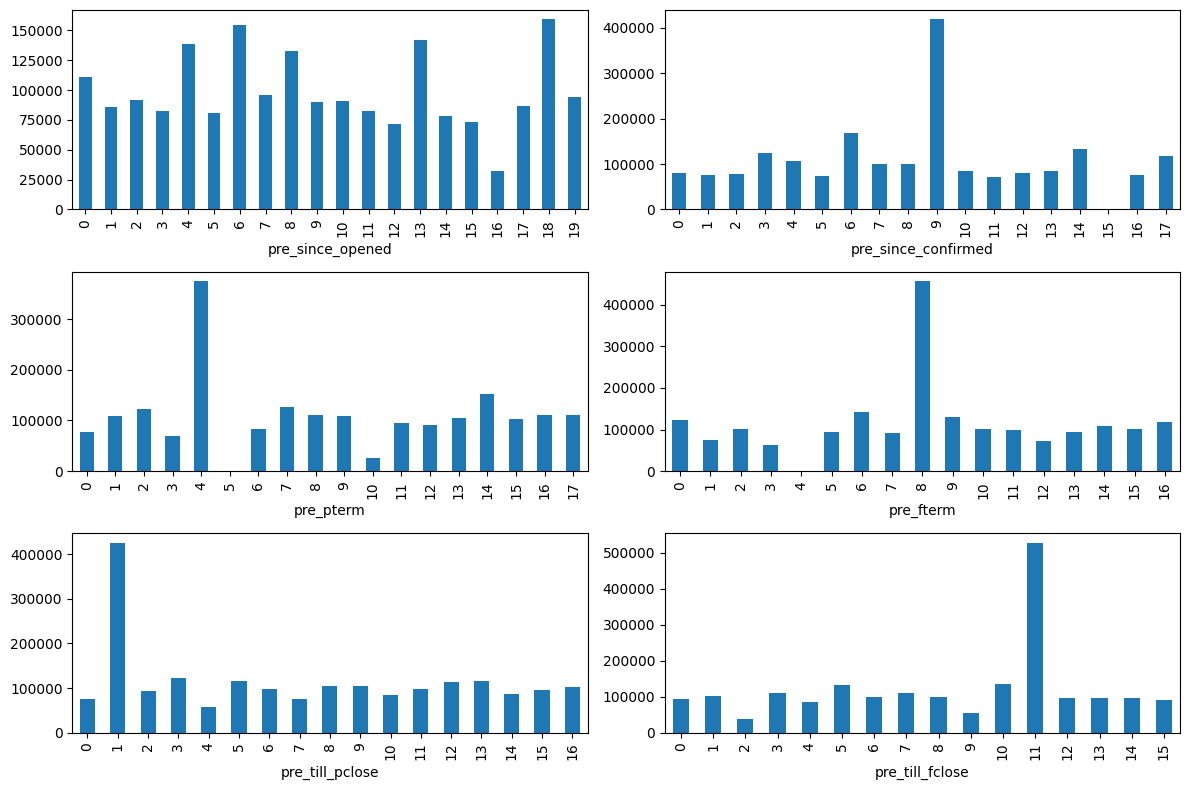

In [12]:
cols = [
    'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
    'pre_fterm', 'pre_till_pclose', 'pre_till_fclose'
]

plot_feature_hists(data_frame, cols, 2, 3, (12, 8))

Видим, что у всех фичей есть серьезные пики распределения. Предположительно, они обоснованы экономическими процессами и периодичностью сбора данных.

Для всех этих фичей будем строить агрегации по min\max\mode. У этого есть экономический смысл: эти агрегации будут показывать возраст самого старого и самого нового события во временном ряду, а также средний возраст этого события.

Теперь рассмотрим фичи, связанные с суммами платежей, кредитными лимитами и суммами задолженностей:

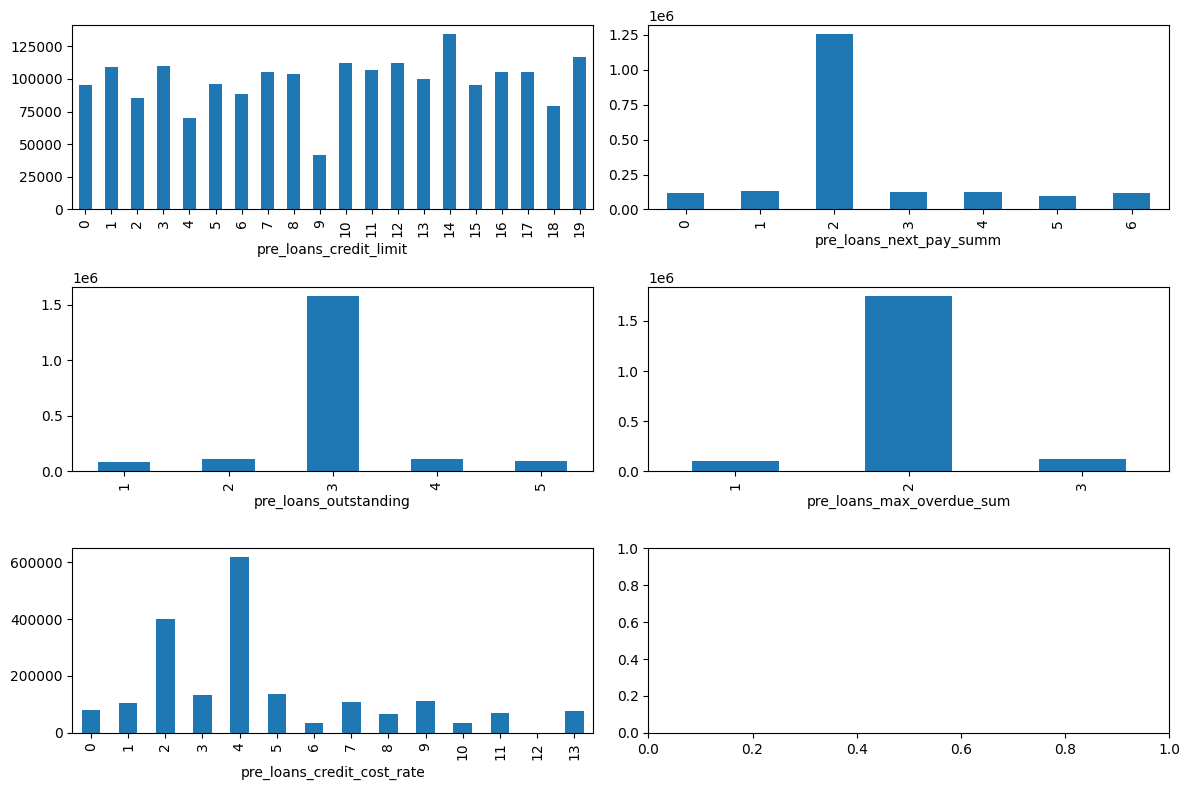

In [13]:
cols = [
    'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
    'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
    'pre_loans_credit_cost_rate',
]

plot_feature_hists(data_frame, cols, 2, 3, (12, 8))

Из гистограмм выше видно, что для pre_loans_credit_limit и pre_loans_credit_cost_rate подходят min\max\mode агрегации, а вот распределение других трех признаков лишает mode агрегацию всякого смысла, однако min\max все еще применимы.

Теперь рассмотрим признаки, отвечающие за число просрочек кредитов на разные промежутки времени:

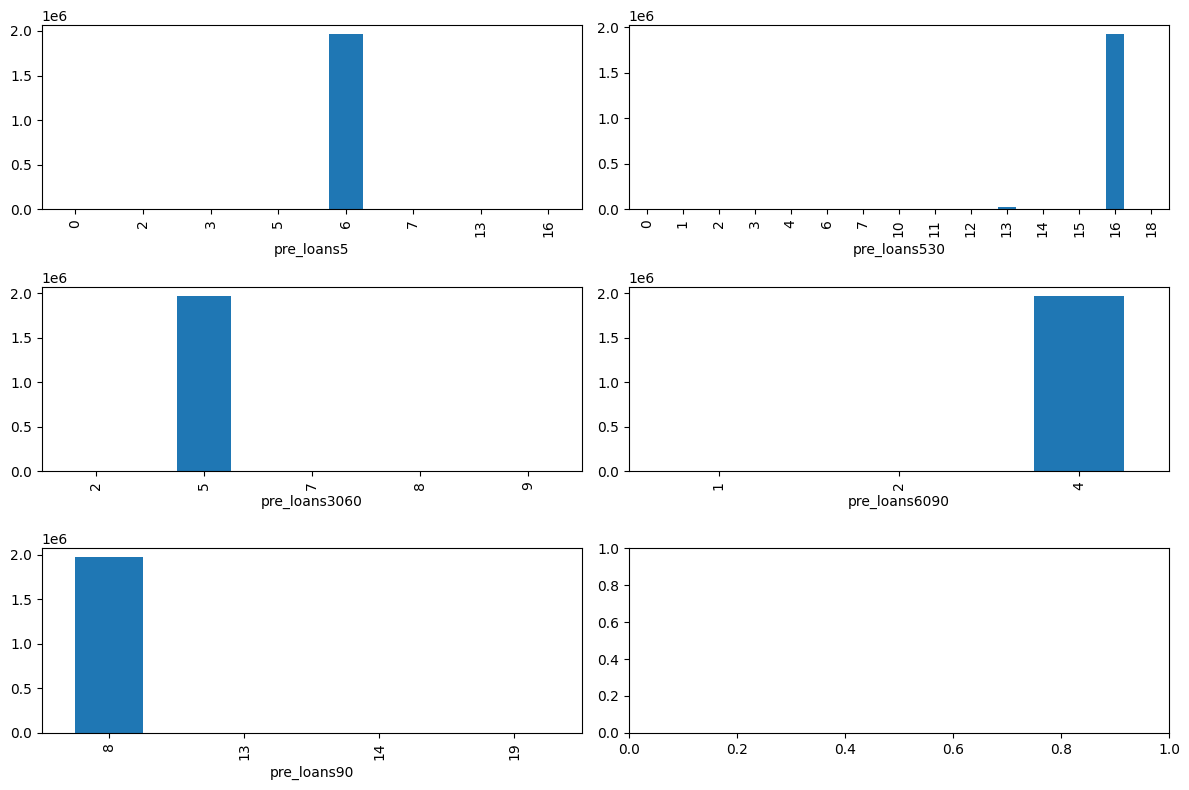

In [14]:
cols = [
    'pre_loans5', 'pre_loans530', 'pre_loans3060',
    'pre_loans6090', 'pre_loans90'
]

plot_feature_hists(data_frame, cols, 2, 3, (12, 8))

Из распределения этих признаков явно видно, что mode\min\max агрегация тут не сработает. Вместо этого для них будем делить уникальные значения по бинам и проводить для каждого count-encoding, чтобы увидеть, были ли вхождения редких значений, и их количество.

Далее рассмотрим признаки-флаги:

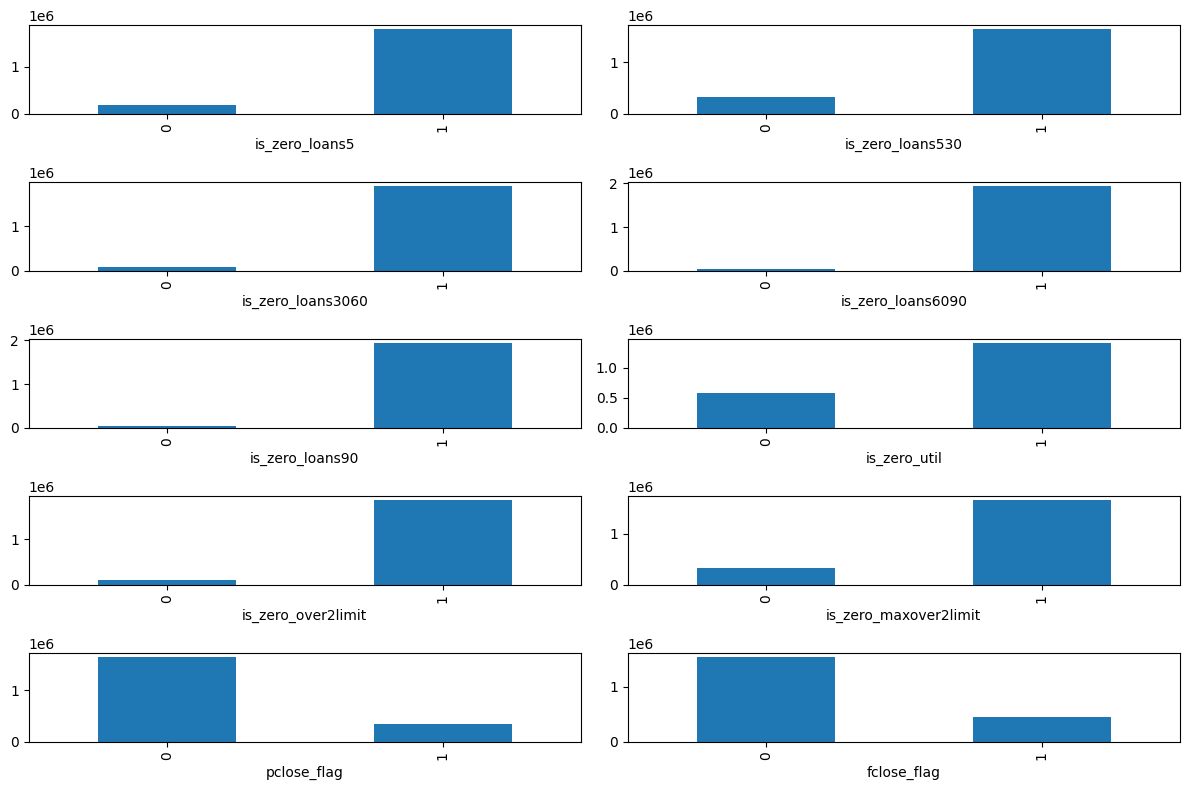

In [15]:
cols = [
    'is_zero_loans5', 'is_zero_loans530',
    'is_zero_loans3060', 'is_zero_loans6090',
    'is_zero_loans90', 'is_zero_util',
    'is_zero_over2limit', 'is_zero_maxover2limit',
    'pclose_flag', 'fclose_flag',
]

plot_feature_hists(data_frame, cols, 2, 5, (12, 8))

Их будем агрегировать по числу вхождений значений.

Рассмотрим теперь статусы ежемесячных платежей за последние N месяцев:

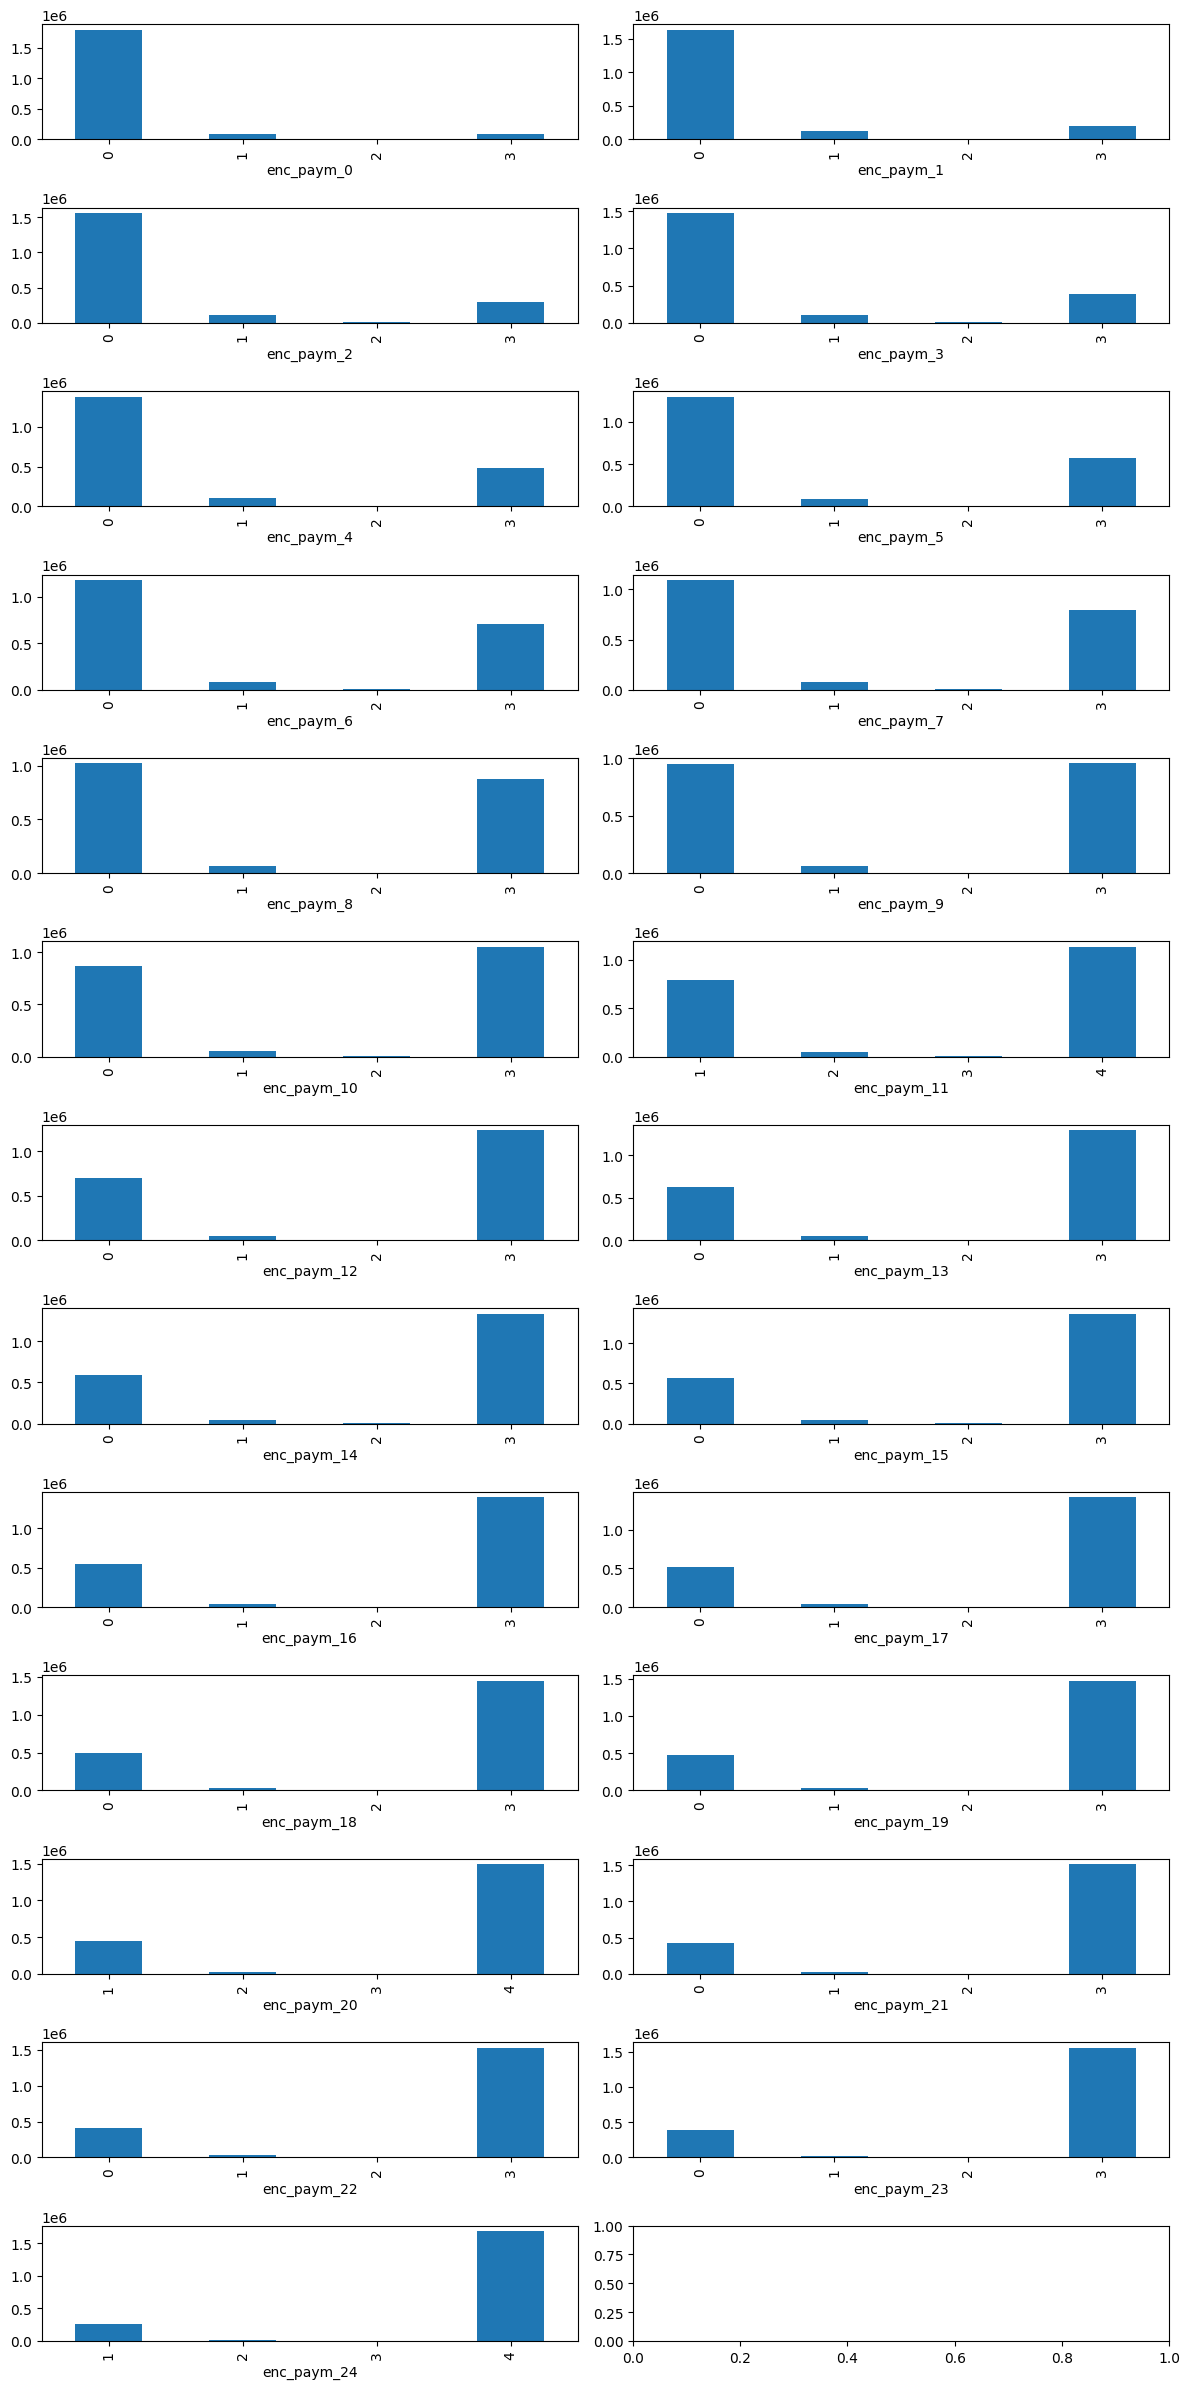

In [16]:
cols = [
    'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4',
    'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8',
    'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
    'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
    'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
    'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
]

plot_feature_hists(data_frame, cols, 2, 13, (12, 24))

Заметим интересную деталь: у enc_paym_11, enc_paym_20, enc_paym_24 метки всех категорий смещены на 1 вправо. Исправим это:

In [17]:
data_frame['enc_paym_11'] = data_frame['enc_paym_11'] - 1

<Axes: xlabel='enc_paym_11'>

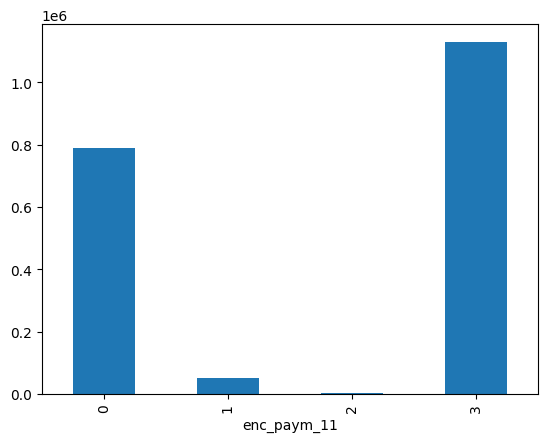

In [18]:
data_frame['enc_paym_11'].value_counts().sort_index().plot.bar()

По-хорошему эти признаки надо бы тоже агрегировать по количеству вхождений, но в таком случае получим 96 новых столбцов только для этих признаков. Это огромный взрыв размерности и многие гигабайты данных, которыми мы не можем раскидываться из-за ограничений по ОЗУ.

Решением будет подсчет общего количества вхождений значений по всем месяцам. Это позволит сократить количество соответствующих столбцов с 24 до 4, а также даст информацию, были ли вообще просрочки, какой категории и в каком количестве.

Теперь рассмотрим фичи, отражающие отношения долгов к кредитному лимиту:

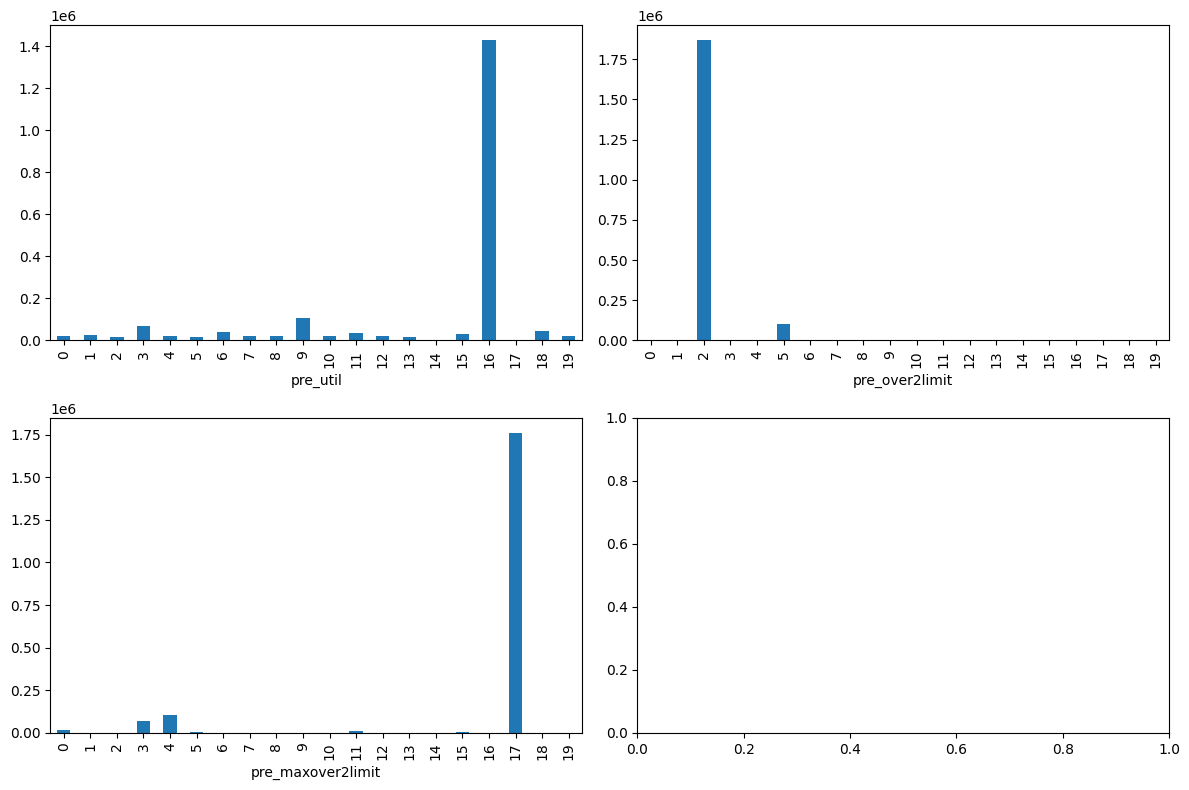

In [19]:
cols = [
    'pre_util', 'pre_over2limit',
    'pre_maxover2limit'
]

plot_feature_hists(data_frame, cols, 2, 2, (12, 8))

Распределения признаков крайне несбаллансированные. Учитывая количество уникальных значений фичей, мы не можем позволить себе OHE для подсчета вхождения всех возможных категорий. Вместо этого будем считать также делить категории на бины и считать вхождения по ним. Это даст информацию о разбросе категорий просрочек у клиента, экстремальных значениях и в целом наличии вхождений значений, отличных от моды.

Рассмотрим, наконец, признаки самого кредитного продукта (статус, валюта, тип):

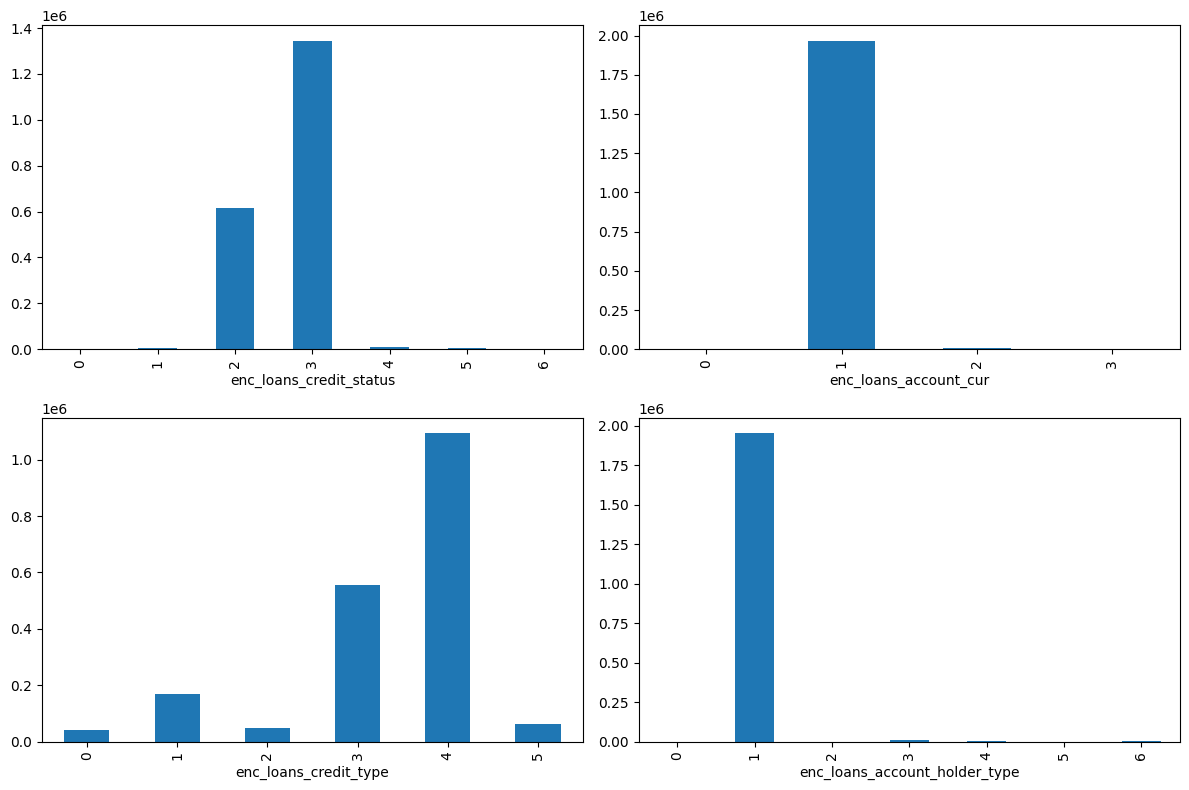

In [20]:
cols = [
    'enc_loans_credit_status', 'enc_loans_account_cur', 'enc_loans_credit_type', 'enc_loans_account_holder_type'
]

plot_feature_hists(data_frame, cols, 2, 2, (12, 8))

Для них будем считать количество вхождений каждого значения.

Рассмотрим типы данных полученного датафрейма (Заметим также, что он один занимает около 1 GB памяти):

In [21]:
data_frame.dtypes

,0
id,int64
rn,int64
pre_since_opened,int64
pre_since_confirmed,int64
pre_pterm,int64
...,...
enc_loans_credit_status,int64
enc_loans_credit_type,int64
enc_loans_account_cur,int64
pclose_flag,int64


In [22]:
data_frame.memory_usage(deep=True)

,0
Index,132
id,15797792
rn,15797792
pre_since_opened,15797792
pre_since_confirmed,15797792
...,...
enc_loans_credit_status,15797792
enc_loans_credit_type,15797792
enc_loans_account_cur,15797792
pclose_flag,15797792


Вес датафрейма можно уменьшить вдвое безо всякой потери качества, переведя 64-битные данные внутри в 32-битные. Точность чисел с плавающей запятой и размер целочисленных значений внутри датафрейма умещаются в 32-битный формат данных целиком.

In [23]:
def reduce_df_size(dataframe: pd.DataFrame) -> pd.DataFrame:
    for col in dataframe.select_dtypes(include=['int64']).columns:
        dataframe[col] = pd.to_numeric(dataframe[col], downcast='integer')

    for col in dataframe.select_dtypes(include=['float64']).columns:
        dataframe[col] = dataframe[col].astype(np.float32)

    return dataframe

In [24]:
data_frame = reduce_df_size(data_frame)

In [25]:
data_frame.dtypes

,0
id,int32
rn,int8
pre_since_opened,int8
pre_since_confirmed,int8
pre_pterm,int8
...,...
enc_loans_credit_status,int8
enc_loans_credit_type,int8
enc_loans_account_cur,int8
pclose_flag,int8


In [26]:
data_frame.memory_usage(deep=True)

,0
Index,132
id,7898896
rn,1974724
pre_since_opened,1974724
pre_since_confirmed,1974724
...,...
enc_loans_credit_status,1974724
enc_loans_credit_type,1974724
enc_loans_account_cur,1974724
pclose_flag,1974724


Почистим память:

In [27]:
import gc

del data_frame
gc.collect()

101078

Базовым подходом к решению этой задачи является построение классической модели машинного обучения на аггрегациях от последовательностей категориальных признаков. В данном случае мы закодируем признаки с помощью count-encoding'а, применим к ним аггрегирование (наиболее очевидными аггрегациями являются среднее и сумма) и обучим на этом градиентный бустинг из реализации lightgbm.

Описанный подход к обработке кредитных историй клиентов реализован в виде класса-трансформера DataAggregator ниже:

In [59]:
%load_ext autoreload
%autoreload 2


def mode_agg(x):
    return pd.Series.mode(x)[0]

# min, max, mean можно сочетать с count/bin
agg_dict = {
    'pre_since_opened': ['min', 'max', mode_agg], # mode бесполезна тут и дальше, у дней
    'pre_since_confirmed': ['min', 'max', mode_agg],
    'pre_pterm': ['min', 'max', mode_agg],
    'pre_fterm': ['min', 'max', mode_agg],
    'pre_till_pclose': ['min', 'max', mode_agg],
    'pre_till_fclose': ['min', 'max', mode_agg],
    'pre_loans_credit_limit': ['min', 'max', mode_agg],
    'pre_loans_next_pay_summ': ['min', 'max'],
    'pre_loans_outstanding': ['min', 'max'],
    'pre_loans_max_overdue_sum': ['min', 'max'],
    'pre_loans_credit_cost_rate': ['min', 'max', mode_agg]
}

process_dict = {
    'pre_util': 'binning',
    'pre_over2limit': 'binning',
    'pre_maxover2limit': 'binning',
    'pre_loans5': 'binning',
    'pre_loans530': 'binning',
    'pre_loans3060': 'binning',
    'pre_loans6090': 'binning',
    'pre_loans90': 'binning',
    'is_zero_loans5': 'count_encode',
    'is_zero_loans530': 'count_encode',
    'is_zero_loans3060': 'count_encode',
    'is_zero_loans6090': 'count_encode',
    'is_zero_loans90': 'count_encode',
    'is_zero_util': 'count_encode',
    'is_zero_over2limit': 'count_encode',
    'is_zero_maxover2limit': 'count_encode',
    'enc_loans_account_holder_type': 'count_encode',
    'enc_loans_credit_status': 'count_encode',
    'enc_loans_credit_type': 'count_encode',
    'enc_loans_account_cur': 'count_encode',
    'pclose_flag': 'count_encode',
    'fclose_flag': 'count_encode'
}


class DataAggregator(object):
    def __init__(self, agg_dict, process_dict, payment_feats, bucket_num):
        self.encoded_feats = None
        self.agg_dict = agg_dict
        self.process_dict = process_dict
        self.payment_feats = payment_feats
        self.bucket_num = bucket_num

    def __count_categories(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe_long = dataframe[['id']+self.payment_feats].melt(
            id_vars='id',
            value_vars=self.payment_feats,
            var_name='feature',
            value_name='value'
        )
        counts = dataframe_long.groupby(['id', 'value']).size().unstack(fill_value=0)
        counts.columns = [f'enc_paym_count_{int(col)}' for col in counts.columns]
        counts = counts.reset_index()
        dataframe = pd.merge(dataframe, counts, on='id', how='left')

        return dataframe

    def __extract_dummies(
            self, col, binning: bool, buckets: int, dataframe: pd.DataFrame
        ) -> Tuple[pd.DataFrame, List[str]]:
        if binning:
            dataframe[col] = pd.qcut(
                dataframe[col],
                q=buckets,
                duplicates='drop'
            )
            grouplist = dataframe[col].unique().tolist()
            grouplist.sort()
            group_mapping = {g:i for i, g in enumerate(grouplist)}
            dataframe[col] = dataframe[col].apply(lambda x: group_mapping[x])
            dataframe[col] = pd.to_numeric(dataframe[col], downcast='integer')

        dummies = pd.get_dummies(dataframe[col], prefix=col)
        dataframe = pd.concat([dataframe, dummies], axis=1)
        dataframe = dataframe.drop(columns=col)

        return (dataframe, dummies.columns.values)

    def __extract_aggregations(
            self,
            dataframe: pd.DataFrame
        ) -> pd.DataFrame:
        agg_dataframe = dataframe.groupby('id').agg(self.agg_dict).reset_index()
        agg_dataframe.columns = [
            f'{col[0]}_{col[1]}' if col[1] else col[0]
            for col in agg_dataframe.columns
        ]

        encoded_features = []
        for col, mode in self.process_dict.items():
            if mode == 'binning':
                dataframe, feats = self.__extract_dummies(col, True, self.bucket_num, dataframe)
                encoded_features.extend(feats)
            elif mode == 'count_encode':
                dataframe, feats = self.__extract_dummies(col, False, self.bucket_num, dataframe)
                encoded_features.extend(feats)

        dataframe = dataframe.groupby('id')[encoded_features].sum().reset_index(drop=False)
        dataframe = pd.merge(dataframe, agg_dataframe, on='id', how='left')

        return dataframe

    def __transform_data(
            self,
            path_to_dataset: str,
            num_parts_to_preprocess_at_once: int = 1,
            num_parts_total: int = 25,
            start_from: int = 0,
            mode: str = 'fit_transform',
            save_to_path=None,
            verbose: bool = False):
        assert mode in ['fit_transform', 'transform'
            ],f'Unrecognized mode: {mode}. Available modes: fit_transform, transform'

        preprocessed_frames = []

        for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                         desc='Transforming sequential data'):
            dataframe = read_parquet_from_local(
                path_to_dataset,
                start_from=start_from+step,
                num_parts_to_read=num_parts_to_preprocess_at_once,
                verbose=verbose
            )
            dataframe['enc_paym_11'] = dataframe['enc_paym_11'] - 1
            dataframe['enc_paym_20'] = dataframe['enc_paym_20'] - 1
            dataframe['enc_paym_24'] = dataframe['enc_paym_24'] - 1
            dataframe = reduce_df_size(dataframe)
            feats = self.__extract_aggregations(dataframe)
            if save_to_path:
                feats.to_parquet(os.path.join(
                    save_to_path, f'processed_chunk_{start_from+step}.pq'
                ))
            preprocessed_frames.append(feats)

        feats = pd.concat(preprocessed_frames)
        feats.fillna(np.uint8(0), inplace=True)
        feat_cols = list(feats.columns.values)
        feat_cols.remove('id')

        if (mode == 'fit_transform'):
            self.encoded_feats = feat_cols
        else:
            assert not self.encoded_feats is None, 'Transformer not fitted'
            for col in self.encoded_feats:
                if not col in feat_cols:
                    feats[col] = np.uint8(0)

        return feats[['id']+self.encoded_feats]

    def fit_transform(
            self,
            path_to_dataset: str,
            num_parts_to_preprocess_at_once: int = 1,
            num_parts_total: int = 50,
            start_from: int = 0,
            save_to_path=None,
            verbose: bool = False):
        return self.__transform_data(
            path_to_dataset=path_to_dataset,
            num_parts_to_preprocess_at_once=num_parts_to_preprocess_at_once,
            num_parts_total=num_parts_total,
            start_from=start_from,
            mode='fit_transform',
            save_to_path=save_to_path,
            verbose=verbose)

    def transform(
            self,
            path_to_dataset: str,
            num_parts_to_preprocess_at_once: int = 1,
            num_parts_total: int = 50,
            start_from: int = 0,
            save_to_path=None,
            verbose: bool = False):
        return self.__transform_data(
            path_to_dataset=path_to_dataset,
            num_parts_to_preprocess_at_once=num_parts_to_preprocess_at_once,
            num_parts_total=num_parts_total,
            start_from=start_from,
            mode='transform',
            save_to_path=save_to_path,
            verbose=verbose)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Создадим директорию для предобработанных признаков обучающей выборки:

In [29]:
!mkdir ./kaggle_data/data_for_competition/train_features

Заполним эту директорию агрегированными данными:

In [61]:
%%time
aggregator = DataAggregator(agg_dict=agg_dict, process_dict=process_dict, payment_feats=payment_feats, bucket_num=3)

_ = aggregator.fit_transform(
        './kaggle_data/data_for_competition/train_data',
        num_parts_to_preprocess_at_once=1,
        num_parts_total=1,
        start_from=0,
        save_to_path='./kaggle_data/data_for_competition/train_features',
        verbose=True)

for i in range(1, 12):
    print(f'Transforming chunk {i}:')
    _ = aggregator.transform(
        './kaggle_data/data_for_competition/train_data',
        num_parts_to_preprocess_at_once=1,
        num_parts_total=1,
        start_from=i,
        save_to_path='./kaggle_data/data_for_competition/train_features',
        verbose=True)
    print(f'Chunk {i} transformed.')

del _
gc.collect()

Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_0.pq



Transforming sequential data: 100%|██████████| 1/1 [04:36<00:00, 276.40s/it]


Transforming chunk 1:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_1.pq



Transforming sequential data: 100%|██████████| 1/1 [04:38<00:00, 278.39s/it]


Chunk 1 transformed.
Transforming chunk 2:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_2.pq



Transforming sequential data: 100%|██████████| 1/1 [04:33<00:00, 273.16s/it]


Chunk 2 transformed.
Transforming chunk 3:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_3.pq



Transforming sequential data: 100%|██████████| 1/1 [04:38<00:00, 278.66s/it]


Chunk 3 transformed.
Transforming chunk 4:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_4.pq



Transforming sequential data: 100%|██████████| 1/1 [04:33<00:00, 273.48s/it]


Chunk 4 transformed.
Transforming chunk 5:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_5.pq



Transforming sequential data: 100%|██████████| 1/1 [04:49<00:00, 289.64s/it]


Chunk 5 transformed.
Transforming chunk 6:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_6.pq



Transforming sequential data: 100%|██████████| 1/1 [04:37<00:00, 277.25s/it]


Chunk 6 transformed.
Transforming chunk 7:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_7.pq



Transforming sequential data: 100%|██████████| 1/1 [04:36<00:00, 276.40s/it]


Chunk 7 transformed.
Transforming chunk 8:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_8.pq



Transforming sequential data: 100%|██████████| 1/1 [04:38<00:00, 278.39s/it]


Chunk 8 transformed.
Transforming chunk 9:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_9.pq



Transforming sequential data: 100%|██████████| 1/1 [04:35<00:00, 275.11s/it]


Chunk 9 transformed.
Transforming chunk 10:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_10.pq



Transforming sequential data: 100%|██████████| 1/1 [04:39<00:00, 279.99s/it]


Chunk 10 transformed.
Transforming chunk 11:


Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/train_data/train_data_11.pq



Transforming sequential data: 100%|██████████| 1/1 [04:37<00:00, 277.83s/it]


Chunk 11 transformed.
CPU times: user 53min 44s, sys: 2min 17s, total: 56min 1s
Wall time: 55min 35s


0

In [62]:
dataset_paths = {
    int(os.path.splitext(filename)[0].split("_")[-1]):
        os.path.join('./kaggle_data/data_for_competition/train_features', filename)
        for filename in os.listdir('./kaggle_data/data_for_competition/train_features')
}

chunks = [dataset_paths[num] for num in sorted(dataset_paths.keys())]

all_feats = set({})
for chunk in chunks:
    pf = ParquetFile(chunk)
    df = pf.to_pandas()
    if not set(df.columns.values) in all_feats:
        all_feats.update(df.columns.values)

for chunk in chunks:
    pf = ParquetFile(chunk)
    df = pf.to_pandas()
    missing = all_feats.difference(set(df.columns.values))
    for col in missing:
        df[col] = np.uint8(0)
    df.to_parquet(chunk)

Рассмотрим теперь механизм кросс-валидации. Учитывая, что мы загружаем данные отдельными партациями, нам не подходит "классический" алгоритм разбиения датасета на train\val выборки.

Дело в том, что при разбиении каждой загружаемой партации на фолды "на месте" мы теряем репрезентативность, так как out-of-fold часть выборки будет локальной, а для адекватной валидации нужно, чтобы OOF охватывала весь датасет.

Более того, без механизма согласования OOF по фолдам мы не сможем собрать аггрегированное предсказание наших моделей на тесте. Это связано с архитектурой решения и будет видно позже.

Итак, рассмотрим теперь следующий механизм кросс-валидации:
1. Создается датафрейм, содержащий id объектов всей (!) выборки. Учитывая, что это единственный int столбец, он не займет критически много места;
2. Этот датафрейм расширяется колонкой fold, которая будет указывать, к валидации какого по счету фолда относится элемент;
3. Колонка fold заполняется с использованием инструмента KFold из scikit_learn. Это стандартный инструмент для разбиения наборов данных на фолды;

На этом этапе мы получаем датафрейм, глобально делящий все объекты из всех партаций в совокупности на фолды для кросс-валидации. Учитывая огромный объем каждой отдельной партации и случайность разбиения на фолды, мы получим примерно одинаковое соотношение объемов train и val частей в индивидуальных партациях.

При обучении модели каждая партация загружается и рассматривается независимо от остальных. Используя полученный на этапе 3 датафрейм, из партации выбираются соответствующие текущему фолду строки. Для итогового случая создается отдельная модель. Она обучается на финальных данных и добавляется в общий ансамбль. Это гарантирует, что все модели ансамбля в совокупности будут обучены на полном объеме данных без исключения.  

К концу обучения общее количество моделей в ансамбле будет равно MxN, по M моделей на каждую партацию, рассмотренную в N разных вариациях разбиения.

Итоговое предсказание на тесте будет получено аггрегированием предсказаний всего ансамбля моделей. Именно на этом месте "стреляет" согласованность моделей в ансамбле.

In [60]:
!rmdir ./kaggle_data/data_for_competition/train_features/.ipynb_checkpoints

In [64]:
id_dfs = []
for chunk in chunks:
    pf = ParquetFile(chunk)
    df = pf.to_pandas(columns=['id'])
    id_dfs.append(df)

kf_ids = pd.concat(id_dfs, ignore_index=True)
kf_ids['fold'] = -1

kf = KFold(n_splits=5, random_state=100, shuffle=True)
for fold, (_, val_idx) in enumerate(kf.split(kf_ids)):
    kf_ids.loc[val_idx, 'fold'] = fold

In [65]:
kf_ids.fold.value_counts()

,count
fold,
1,600000
4,600000
2,600000
0,600000
3,600000


Подгружаем в память целевую переменную из train_target.csv:

In [66]:
train_target = pd.read_csv('./kaggle_data/data_for_competition/train_target.csv')

In [67]:
%%time

models = []

tree_parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 5,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_estimators': 2000,
    'min_data_in_leaf': 256,
    'verbosity': -1
}

train_paths = [
    os.path.join('./kaggle_data/data_for_competition/train_features', filename)
    for filename in os.listdir('./kaggle_data/data_for_competition/train_features')
]

for fold_ in range(5):
    print(f'Training with fold {fold_} started')

    val_preds_list = []
    val_targets_list = []

    for path in train_paths:
        pf = ParquetFile(path)
        df = pf.to_pandas()
        df = df.merge(kf_ids, on='id')
        df = df.merge(train_target, on='id')

        val = df[df['fold'] == fold_]
        train = df[df['fold'] != fold_]

        if val.empty or train.empty:
            print('Skipped: no val or train data for this fold')
            continue

        features = [c for c in train.columns if c not in ('id', 'flag', 'fold')]

        lgb_model = lgb.LGBMClassifier(**tree_parameters)
        lgb_model.fit(
            train[features], train.flag.values,
            eval_set=[(val[features], val.flag.values)]
        )

        preds = lgb_model.predict_proba(val[features])[:, 1]
        val_preds_list.append(preds)
        val_targets_list.append(val['flag'].values)
        models.append(lgb_model)

        del df, val, train
        gc.collect()

    fold_preds = np.concatenate(val_preds_list)
    fold_targets = np.concatenate(val_targets_list)
    print('CV ROC-AUC: ', roc_auc_score(fold_targets, fold_preds))

    print(f'Training with fold {fold_} completed')

Training with fold 0 started
CV ROC-AUC:  0.7103432350811802
Training with fold 0 completed
Training with fold 1 started
CV ROC-AUC:  0.711574177582628
Training with fold 1 completed
Training with fold 2 started
CV ROC-AUC:  0.7102565034570572
Training with fold 2 completed
Training with fold 3 started
CV ROC-AUC:  0.7070353291904954
Training with fold 3 completed
Training with fold 4 started
CV ROC-AUC:  0.7111301099741392
Training with fold 4 completed
CPU times: user 1h 56min 28s, sys: 32.1 s, total: 1h 57min
Wall time: 1h 57min 34s


Теперь проделаем то же самое для тестовой выборки:

In [70]:
!mkdir ./kaggle_data/data_for_competition/test_features

In [71]:
test_data = aggregator.transform(
    './kaggle_data/data_for_competition/test_data',
    num_parts_to_preprocess_at_once=2,
    num_parts_total=2,
    save_to_path='./kaggle_data/data_for_competition/test_features',
    verbose=True)

for col in test_data.select_dtypes(include=['int64']).columns:
    test_data[col] = pd.to_numeric(test_data[col], downcast='integer')

for col in test_data.select_dtypes(include=['float64']).columns:
    test_data[col] = test_data[col].astype(np.float32)

Transforming sequential data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
./kaggle_data/data_for_competition/test_data/test_data_0.pq
./kaggle_data/data_for_competition/test_data/test_data_1.pq



Transforming sequential data: 100%|██████████| 1/1 [09:40<00:00, 580.50s/it]


In [ ]:
test_target = pd.read_csv('./kaggle_data/data_for_competition/test_target.csv')
test_feats = list(test_data.columns.values)
test_feats.remove('id')

missing = all_feats.difference(set(test_data.columns.values))
print(missing)
for col in missing:
    test_data[col] = np.uint8(0)

score = np.zeros(len(test_data))
for model in tqdm(models):
    try:
        score += model.predict_proba(test_data[test_feats])[:, 1]/len(models)
    except ValueError as e:
        print(f'{e}. Skipping the model.')
        continue

submission = pd.DataFrame({
    'id': test_data['id'].values,
    'score': score
})

In [77]:
submission

,id,score
0,3000000,0.137226
1,3000001,0.161160
2,3000002,0.210842
3,3000003,0.230970
4,3000004,0.152989
...,...,...
499995,3499995,0.146943
499996,3499996,0.268017
499997,3499997,0.153884
499998,3499998,0.153722
